In [7]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv

In [8]:
# importing all following data and putting in a graph
pkl_file = open('Unfollower/15weeks_friend_dict.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

week = 0
for key, values in mydict2.items():
    if len(values[week]) == 0:
        mydict2[key] = []
        continue
    new = values[week][1]
    mydict2[key] = new

print(mydict2)
# mydict2 has format:
# user_id: [following_user_id1, following_user_id2...]

In [9]:
# forrest fire sampling implementation and use 
def forest_fire_sampling(graph_dict, initial_burn_probability, secondary_burn_probability, max_samples=None):
    # Choose a random start node
    random.seed(947)
    start_node = random.choice(list(graph_dict.keys()))
    
    # Force starting node to have at least 100 friends 
    if len(graph_dict[start_node]) < 100:
        start_node = random.choice(list(graph_dict.keys()))
    sampled_nodes = set([start_node])
    burning_nodes = set([start_node])
    
    while burning_nodes:
        new_burning_nodes = set()
        for node in burning_nodes:
            # For each neighbor, decide if it catches fire based on the burn probability
            for neighbor in graph_dict[node]:
                if neighbor not in sampled_nodes:
                    if random.random() < (initial_burn_probability if node == start_node else secondary_burn_probability):
                        new_burning_nodes.add(neighbor)
                        sampled_nodes.add(neighbor)
                        if max_samples and len(sampled_nodes) >= max_samples:
                            return sampled_nodes
        burning_nodes = new_burning_nodes

    return sampled_nodes

# sampling has undeterministic results where sample may have few nodes or many nodes depending on whether random starting node has many or few neighbors. We may want to force the starting node to have more than 10 friends. 

sample = forest_fire_sampling(mydict2, 0.2, 0.1, max_samples=1000)
shortened_dict = defaultdict(list)
print(len(mydict2))
for k in mydict2:
    if k in sample: 
        for v in mydict2[k]:
            if v in sample: 
                shortened_dict[k].append(v)

print(len(shortened_dict))

In [10]:
import community as community_louvain
# Creating sample graph and drawing it 
subset_followers_graph = nx.DiGraph()
for k, v in shortened_dict.items():
    for neighbor in v:
        subset_followers_graph.add_edge(k, neighbor)

print(subset_followers_graph.number_of_nodes())
partition = community_louvain.best_partition(subset_followers_graph)
community_colors = {node: partition[node] for node in subset_followers_graph.nodes()}
values = [community_colors.get(node) for node in subset_followers_graph.nodes()]
print(partition)

# print(community.louvain_communities(subset_followers_graph))

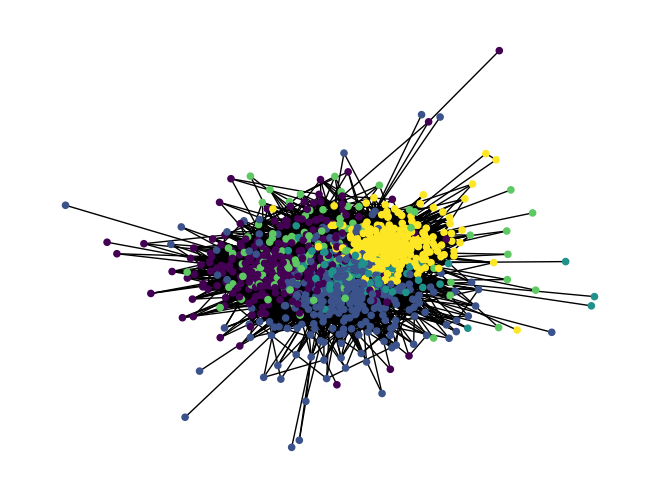

In [72]:
# Draw the graph node
nx.draw(subset_followers_graph, with_labels=False, node_size=20, node_color=values)

# Display the graph
plt.show()

In [7]:
removed_edges_graph = subset_followers_graph.copy()
print("edges before removal:",removed_edges_graph.number_of_edges())
def remove_edges(G, k):
    # Calculate the number of edges to remove (10% of total edges)
    num_edges_to_remove = int(k * G.number_of_edges())
    
    # Get the list of all edges in the graph
    all_edges = list(G.edges())
    random.seed(947)
    # Randomly select edges to remove
    removed_edges = random.sample(all_edges, num_edges_to_remove)
    
    # Remove the selected edges from the graph
    G.remove_edges_from(removed_edges)
    
    return set(removed_edges)

removed_edges = remove_edges(removed_edges_graph,0.1)
removed_nodes_set = set()
for edge in removed_edges:
    removed_nodes_set.add(edge[0])
print("edges after removal:", removed_edges_graph.number_of_edges())
print(f"density: {nx.density(removed_edges_graph)}")

edges before removal: 27424
edges after removal: 24682
density: 0.024706706706706705


In [8]:
def jaccard_prediction(G, k):
    predictions = {}
    for node1 in removed_nodes_set:
        node1_friends = set(G.neighbors(node1))
        scores = []
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            node2_friends = set(G.neighbors(node2))
            total_friends = node1_friends.union(node2_friends)
            numerator = sorted(w for w in node1_friends if w in node2_friends)
            if len(total_friends)==0: score=0
            else: score = len(numerator)/len(total_friends)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
    
    predicted_edges = set()
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges

In [9]:
def preferential_attachment_prediction(G, k):
    predictions = {}
    for node1 in removed_nodes_set:
        scores = []
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            
            score = G.degree(node1) * G.degree(node2)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
            
    predicted_edges = set()
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges


In [15]:
def assess_accuracy(predicted_edges, actual_edges):
    actual_edge_set = set(actual_edges)
    predicted_edge_set = set(predicted_edges)
    
    # Calculate True Positive, False Positive, True Negative, False Negative
    true_positive = len(actual_edge_set.intersection(predicted_edge_set))
    false_positive = len(predicted_edge_set - actual_edge_set)
    false_negative = len(actual_edge_set - predicted_edge_set)
    
    # Calculate precision, recall, and f1 score
    
    # accuracy of positive predictions - if we predicted edge, is there actually edge?
    precision = true_positive / (true_positive + false_positive)
    
    # if there is edge, % of time we predict edge accurately?
    recall = true_positive / (true_positive + false_negative)
    
    # means of balancing
    if precision == 0 and recall == 0: f1_score = 0
    else: f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print the results
    print(f"Precision: {precision:.2f}", end=" ")
    print(f"Recall: {recall:.2f}", end = " ")
    print(f"F1 Score: {f1_score:.2f}")

In [18]:
print("Jaccard")
k = 0
while k < 1:
    jaccard_coefficient_graph_copy = removed_edges_graph.copy()
    jaccard_predicted_edges = jaccard_prediction(jaccard_coefficient_graph_copy, k)
    if len(jaccard_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(jaccard_predicted_edges, removed_edges)
    k += 0.1

print("Preferential")
k = 10000
while k < 100000:
    preferential_graph_copy = removed_edges_graph.copy()
    preferential_predicted_edges = preferential_attachment_prediction(preferential_graph_copy, k)
    if len(preferential_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(preferential_predicted_edges, removed_edges)
    k += 10000

Jaccard
k=0:
Precision: 0.01 Recall: 0.89 F1 Score: 0.02
k=0.1:
Precision: 0.04 Recall: 0.36 F1 Score: 0.07
k=0.2:
Precision: 0.09 Recall: 0.08 F1 Score: 0.08
k=0.30000000000000004:
Precision: 0.18 Recall: 0.02 F1 Score: 0.03
k=0.4:
Precision: 0.29 Recall: 0.00 F1 Score: 0.01
k=0.5:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.6:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.7:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.7999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.8999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.9999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
Preferential
k=10000:
Precision: 0.02 Recall: 0.23 F1 Score: 0.04
k=20000:
Precision: 0.04 Recall: 0.07 F1 Score: 0.05
k=30000:
Precision: 0.06 Recall: 0.02 F1 Score: 0.03
k=40000:
Precision: 0.08 Recall: 0.01 F1 Score: 0.01
k=50000:
Precision: 0.10 Recall: 0.00 F1 Score: 0.00
k=60000:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00


In [20]:
# Get adjacency matrix
node_list = list(removed_edges_graph.nodes())

# Create a dictionary that maps node to index
node_to_index = {node: index for index, node in enumerate(node_list)}

A_sgd_factorize = nx.to_numpy_array(removed_edges_graph, nodelist=node_list)

def sgd_factorize(A, K, iterations=1000000, learning_rate=0.01, lambda_reg=0.02):
    """
    Factorizes the matrix A into the product of two matrices U and V using SGD.
    A: Adjacency matrix
    K: Number of latent features
    iterations: Number of iterations for SGD
    learning_rate: Learning rate for SGD updates
    lambda_reg: Regularization parameter
    """
    N, M = A.shape
    U = np.random.rand(N, K)
    V = np.random.rand(M, K)
    losses = []  # to store the loss values

    # SGD iterations
    for it in range(iterations):
        # Randomly select a non-zero element from A
        i, j = np.random.choice(N), np.random.choice(M)
        if A[i, j] > 0:
            # Compute prediction and error
            pred = np.dot(U[i, :], V[j, :].T)
            e = A[i, j] - pred

            # Update U and V
            U[i, :] += learning_rate * (e * V[j, :] - lambda_reg * U[i, :])
            V[j, :] += learning_rate * (e * U[i, :] - lambda_reg * V[j, :])
            
            # Compute the loss for this iteration (simplified version)
            loss = e**2
            losses.append(loss)
    
    return U, V, losses

K = 10  # example choice, this could be tuned
U, V, losses = sgd_factorize(A_sgd_factorize, K, learning_rate=0.1)

reconstructed_A_sgd_factorize = np.dot(U, V.T)

578246
2742
Precision: 0.00 Recall: 0.68 F1 Score: 0.01


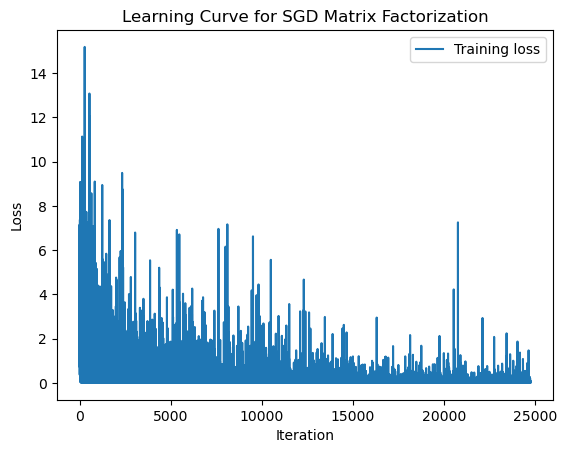

In [27]:
# Assuming U and V are the factorized matrices and you've reconstructed A as reconstructed_A
threshold = 0.9 #Example threshold for determining an edge
sgd_factorize_predicted_edges = set()

for i in range(reconstructed_A_sgd_factorize.shape[0]):
    # only give link predictions for removed nodes set
    if node_list[i] not in removed_nodes_set:
        continue
    for j in range(reconstructed_A_sgd_factorize.shape[1]):
        if i != j and reconstructed_A_sgd_factorize[i, j] >= threshold and A_sgd_factorize[i][j] != 1:   # Assuming no self-loops
            node_i = node_list[i]
            node_j = node_list[j]
            sgd_factorize_predicted_edges.add((node_i, node_j))

print(len(sgd_factorize_predicted_edges))
print(len(removed_edges))
assess_accuracy(sgd_factorize_predicted_edges, removed_edges)

In [ ]:
# Plot the learning curve
plt.plot(losses, label='Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Learning Curve for SGD Matrix Factorization')
plt.legend()
plt.show()

In [ ]:
# Start of new GNN
pip install dgl

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random

In [23]:
edge_list = list(subset_followers_graph.edges())
node_list = list(subset_followers_graph.nodes())
num_nodes = len(node_list)
# Create a dictionary that maps node to index
node_to_i = {node: index for index, node in enumerate(node_list)}
edges = [(node_to_i[edge[0]], node_to_i[edge[1]]) for edge in edge_list]
print(len(edges))
print(num_nodes)
# print(node_to_i)

26118
1000
{'1556132462': 0, '240846621': 1, '10671162': 2, '14517215': 3, '11493602': 4, '88782825': 5, '194203770': 6, '136385823': 7, '19819769': 8, '750093': 9, '8960202': 10, '132414313': 11, '40144128': 12, '10313732': 13, '44973000': 14, '18341734': 15, '18805477': 16, '634739719': 17, '82859989': 18, '807515': 19, '1873322353': 20, '10414152': 21, '9527212': 22, '748143452': 23, '26118912': 24, '14254846': 25, '21094530': 26, '2317884102': 27, '340350928': 28, '14392797': 29, '15160540': 30, '22543612': 31, '5415182': 32, '14111408': 33, '149627584': 34, '1363397682': 35, '14337485': 36, '6270652': 37, '359622624': 38, '3410447714': 39, '887992016': 40, '881959726958862337': 41, '2784575957': 42, '359831209': 43, '792035592': 44, '60487876': 45, '739626641450635265': 46, '882511862524465152': 47, '2865100348': 48, '3874714693': 49, '837133583558987776': 50, '893369040181182464': 51, '180333300': 52, '44073696': 53, '800067317702881280': 54, '801879070766153728': 55, '8246693006

In [28]:
# Example edges, replace it with the edges of our graph, same format
# edges = [(34, 6), (29, 186), (18, 62), (140, 216), (75, 137), (149, 160), (279, 38), (238, 234), (66, 158), (169, 235), (24, 172), (65, 135), (163, 143), (213, 227), (138, 201), (209, 57), (220, 50), (295, 245), (120, 115), (76, 184), (2, 205), (142, 86), (6, 68), (95, 126), (205, 277), (221, 242), (159, 54), (205, 146), (190, 14), (166, 208), (127, 87), (132, 166), (196, 220), (6, 275), (209, 109), (266, 147), (59, 64), (268, 93), (261, 145), (125, 123), (254, 95), (207, 244), (236, 40), (145, 25), (260, 135), (76, 243), (159, 57), (128, 130), (199, 26), (236, 24), (247, 3), (231, 284), (226, 121), (39, 64), (58, 193), (18, 92), (207, 2), (261, 152), (167, 151), (98, 194), (263, 25), (169, 263), (169, 58), (225, 132), (108, 282), (136, 110), (187, 242), (168, 85), (65, 51), (61, 191), (266, 128), (203, 137), (112, 187), (17, 61), (168, 58), (176, 273), (269, 100), (299, 166), (81, 170), (258, 138), (146, 33), (287, 290), (69, 186), (55, 44), (137, 170), (77, 80), (247, 81), (10, 56), (300, 80), (256, 291), (53, 18), (158, 21), (265, 204), (151, 234), (35, 81), (158, 83), (133, 63), (223, 191), (15, 267), (235, 268)]

# Change 100 to be the number of edges in our graph
#labels = [1] * 100
labels = [1] * len(edges)

# Non-existent edges to train, change the number to the number of edges we have
# num_fake_edges = 100
num_fake_edges = len(edges)

# Generate non-existent edges and labels
fake_edges = []
fake_labels = [0] * num_fake_edges
edge_set = set(edge for edge in edges)
for _ in range(num_fake_edges):
    # Generate random nodes for fake edges
    # Change (1, 300) to the number of nodes we have using dictionary values
    #fake_edge = (random.randint(1, 300), random.randint(1, 300))
    fake_edge = (random.randint(0, num_nodes-1), random.randint(0, num_nodes-1))
    
    while fake_edge in edge_set:
        # Change (1, 300) to the number of nodes we have using dictionary values
#         fake_edge = (random.randint(1, 300), random.randint(1, 300))
        fake_edge = (random.randint(0, num_nodes-1), random.randint(0, num_nodes-1))
     
    fake_edges.append(fake_edge)
    edge_set.add(fake_edge)

all_edges = edges + fake_edges
all_labels = labels + fake_labels

print("All Edges:", all_edges)
print("All Labels:", all_labels)

All Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (1, 357), (1, 482), (1, 23), (1, 156), (1, 5), (1, 13), (1, 175), (1, 32), (1, 367), (1, 179), (1, 253), (1, 162), (1, 119), (1, 29), (1, 365), (1, 122), (1, 158), (1, 352), (1, 8), (1, 31), (1, 2), (1, 30), (1, 440), (2, 0), (2, 326), (2, 159), (2, 310), (2, 226), (2, 418), (2, 573), (2, 339), (2, 352), (2, 102), (2, 357), (2, 27), (2, 6), (2, 11), (2, 156), (2, 499), (2, 119), (2, 346), (2, 500), (2, 13), (2, 115), (2, 253), (2, 440), (2, 442), (2, 745), (2, 167), (2, 164), (2, 570), (2, 32), (2, 176), (2, 367), (2, 137), (2, 29), (2, 15), (2, 177), (2, 14), (2, 118), (2, 120), (2, 171), (2, 10), (2, 179), (2, 19), (2, 166), (2, 131), (2, 169), (2, 8), (2, 122), (2, 9), (2, 154), (2, 178), (2, 168), (2, 30), (2, 342), (3, 436), (3, 8), (3, 321), (3, 102), (3, 352), (3, 297), (3

In [29]:
from sklearn.model_selection import train_test_split

# Change 200 to the sum of our real edges + fake edges
indices = list(range(200))
random_seed = 42

import random
random.seed(random_seed)
random.shuffle(indices)

# Change 180 to be 85% of the edges
train_indices, test_indices = indices[:180], indices[180:]
X_train, X_test = train_test_split(all_edges, test_size=0.1, random_state=random_seed)
y_train, y_test = train_test_split(all_labels, test_size=0.1, random_state=random_seed)

In [30]:
# No need to change anything in this block
dgl.load_backend('pytorch')
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = dgl.nn.SAGEConv(in_feats, hidden_size, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(hidden_size, out_feats, aggregator_type='mean')

    def forward(self, g, features):
        # Apply the first GraphSAGE layer
        x = F.relu(self.conv1(g, features))
        # Apply the second GraphSAGE layer
        x = self.conv2(g, x)
        return x

class EdgePredictionModel(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(EdgePredictionModel, self).__init__()
        self.sage = GraphSAGE(in_feats, hidden_size, out_feats)

    def forward(self, g, features):
        # Obtain node representations using GraphSAGE
        node_reps = self.sage(g, features)
        # Edge prediction using dot product of node representations
        src, dst = g.edges()
        src_repr = node_reps[src]
        dst_repr = node_reps[dst]
        edge_scores = torch.sum(src_repr * dst_repr, dim=1)
        return edge_scores

# Create a DGL graph from the training edge list
src_nodes_train, dst_nodes_train = zip(*X_train)
g_train = dgl.graph((src_nodes_train, dst_nodes_train))

# Define the number of input features, hidden size, and output features
in_feats = 1  # In this case, there are no node features
hidden_size = 16
out_feats = 1  # For binary edge prediction

# Initialize the model
model = EdgePredictionModel(in_feats, hidden_size, out_feats)

# Random initialization of node features for training and testing graphs
features_train = torch.randn(g_train.num_nodes(), in_feats)

# Define loss function and optimizer (you may need to adjust these based on your task)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass for training
    edge_scores_train = model(g_train, features_train)
    
    # Apply a threshold of 0.5 to obtain binary predictions
    predictions_train = (torch.sigmoid(edge_scores_train) >= 0.5).float()
    
    # Example: Assuming you have ground truth labels for training edges
    labels_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Assuming binary classification, you can use binary cross-entropy loss
    loss_train = criterion(edge_scores_train, labels_train)
    
    loss_train.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_train.item()}")

Epoch 1/10, Loss: 0.7723425626754761
Epoch 2/10, Loss: 0.738322377204895
Epoch 3/10, Loss: 0.7215628027915955
Epoch 4/10, Loss: 0.7135684490203857
Epoch 5/10, Loss: 0.7088732123374939
Epoch 6/10, Loss: 0.7051296234130859
Epoch 7/10, Loss: 0.7017863988876343
Epoch 8/10, Loss: 0.6989560723304749
Epoch 9/10, Loss: 0.6967716813087463
Epoch 10/10, Loss: 0.6952338218688965


In [31]:
# No need to change anything in this block
# Create a DGL graph from the test edge list
src_nodes_test, dst_nodes_test = zip(*X_test)
g_test = dgl.graph((src_nodes_test, dst_nodes_test))

# Random initialization of node features for the test graph
features_test = torch.randn(g_test.num_nodes(), in_feats)

# Forward pass for testing
model.eval()
with torch.no_grad():
    edge_scores_test = model(g_test, features_test)

# Apply a threshold of 0.5 to obtain binary predictions
predictions_test = (torch.sigmoid(edge_scores_test) >= 0.5).float()

# Calculate accuracy
correct_predictions = torch.sum(predictions_test == torch.tensor(y_test)).item()
total_samples = len(y_test)
accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.49157733537519144
